In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pickle
import glob
import traceback

from scipy import stats as sc_stats
from scipy.special import gamma,loggamma
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

2023-05-15 10:00:34.619533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import sys
import os
from os.path import dirname
sys.path.append(dirname("../../"))

In [4]:
from src.edl import dense_layers,dense_loss
from src.weibull_edl import loss_and_layers
from src.exp_utils import synthetic

In [5]:
%load_ext autoreload
%autoreload 2

### experiment variable

In [10]:
EXP_NAME = "exp3" #experiment name
N_EPS = 5 #number of eps values to try
N_REGUL = 10 #number of regularisation values to try

In [11]:
base_dir = f"../../exp_results/{EXP_NAME}"

if len(os.listdir(base_dir)) == 0:
    print(f"{base_dir} is empty")
else:    
    print(f"{base_dir} is not empty, Removing files")
    [os.remove(f) for f in glob.glob(base_dir+"/*")]

../../exp_results/exp3 is not empty, Removing files


### Helper funcs

In [12]:
def plot_results(ax, mu, var, model_type, n): 
    ax.plot(x_test,y_test,label="True Test",alpha = 1.0,color="black")
    ax.scatter(x_train,y_train,label="Train")
    ax.plot(x_test.reshape(n), mu, zorder=3, label="Mean Pred",color="red", alpha = 0.5)
    if model_type == "proposed":
        a = 0.5
        b = 1
        var_check = np.sqrt(var)
    else:
        a = 2
        b = 8
        var_check = var
    ax.fill_between(x=x_test.reshape(n),\
                 y1=(mu - a * var_check).reshape(n), \
                 y2=(mu + a * var_check).reshape(n),\
                 label=f"{a} std PI",color="grey",alpha=0.7)
    ax.fill_between(x=x_test.reshape(n),\
                 y1=(mu - b * var_check).reshape(n), \
                 y2=(mu + b * var_check).reshape(n),\
                 label=f"{b} std PI",color="pink",alpha=0.2)
#     ax.set_ylim(-10,200)
    ax.legend()
    ax.set_title(f"{model_type} Model")

### Experiment for synthetic data

In [13]:
results_dict={}
model_dict={}
data_dict={}

eps_list = np.linspace(0.2,0.4,N_EPS)
for eps in eps_list:
    #a.gen synthetic data
    x_train, y_train = synthetic.gen_data_weibulll(-4, 4, 3400, eps)
    x_test, y_test = synthetic.gen_data_weibulll(-5, 5, 3400, eps, train=False)
    data_dict[eps] = (x_train, y_train, x_test, y_test)
    
    #b.get k from train data
    rv = sc_stats.weibull_min.fit(y_train, floc=0.0)
    k=float(rv[0])
    print (f"For eps={eps}, fitted k ={k}")
    
    #c.plot data and save fig
    fig,ax = plt.subplots(1,1)
    ax.scatter(x_train,y_train,label="Train")
    ax.plot(x_test,y_test,label="Test",alpha = 0.5, color="black")
    ax.legend()
    ax.set_title(f"$y \sim x^2 + {eps:.3f}*weibull(shape=1.6)$")
    fig.savefig(base_dir+f"/data_gen_eps={eps}.png")
    plt.close()
    
    #d.initialise and run benchmark model
    results_benchmark_eps = {}
    for c_i in np.logspace(-6,-1,N_REGUL):
        try:
            print (f"Fitting for c={c_i}")
            print("fitting benchmark")
            #run benchmark model
            mu_i, var_i, y_pred_train_i, y_pred_test_i,\
            benchmark_model_i, hist_i = synthetic.results_benchmark_model(c_i,x_train,y_train,x_test)
            a,b = synthetic.metrics_benchmark(y_train,y_pred_train_i)
            results_dict[(eps,c_i,"benchmark","train")] = {
                "mse":a, "nll":b, "loss": hist_i.history["loss"][-1],
            }
            c,d = synthetic.metrics_benchmark(y_test,y_pred_test_i)
            results_dict[(eps,c_i,"benchmark","test")] = {
                "mse":c, "nll":d
            }
            model_dict[(eps,c_i,"benchmark")] = benchmark_model_i
            
            print("fitting proposed")
            #run proposed model
            mu_prop_i, var_prop_i, y_pred_train_prop_i,\
            y_pred_test_prop_i, proposed_model_i, hist_prop_i = synthetic.results_weibull_model(c_i,x_train,y_train,x_test,k,0)
            a1,b1 = synthetic.metrics_proposed(y_train,y_pred_train_prop_i,k)
            results_dict[(eps,c_i,"proposed","train")] = {
                "mse":a1, "nll":b1, "loss": hist_prop_i.history["loss"][-1],
            }
            c1,d1 = synthetic.metrics_proposed(y_test,y_pred_test_prop_i,k)
            results_dict[(eps,c_i,"proposed","test")] = {
                "mse":c1, "nll":d1
            }
            model_dict[(eps,c_i,"proposed")] = proposed_model_i
            
            #plot the results
            fig,ax = plt.subplots(1,2,figsize=(12,6))
            plot_results(ax[0],mu_i,var_i,"benchmark",n=3400)
            plot_results(ax[1],mu_prop_i,var_prop_i,"proposed",n=3400)
            fig.suptitle(f"eps={eps}, c= {c_i}")
            fig.savefig(base_dir+f"/results_eps={eps},c={c_i}.png")
            plt.close()
        except Exception as e:
            print (f"Error for eps={eps}, c= {c_i}")
            traceback.print_exc()
        print()

For eps=0.2, fitted k =0.9826973017380234
Fitting for c=1e-06
fitting benchmark
fitting proposed

Fitting for c=3.5938136638046257e-06
fitting benchmark
fitting proposed

Fitting for c=1.2915496650148827e-05
fitting benchmark
fitting proposed

Fitting for c=4.641588833612782e-05
fitting benchmark
fitting proposed

Fitting for c=0.0001668100537200059
fitting benchmark
fitting proposed

Fitting for c=0.0005994842503189409
fitting benchmark
fitting proposed

Fitting for c=0.0021544346900318843
fitting benchmark
fitting proposed

Fitting for c=0.007742636826811277
fitting benchmark
fitting proposed

Fitting for c=0.02782559402207126
fitting benchmark
fitting proposed

Fitting for c=0.1
fitting benchmark
fitting proposed

For eps=0.25, fitted k =1.0018228607285193
Fitting for c=1e-06
fitting benchmark
fitting proposed

Fitting for c=3.5938136638046257e-06
fitting benchmark
fitting proposed

Fitting for c=1.2915496650148827e-05
fitting benchmark
fitting proposed

Fitting for c=4.641588833612

### Save results

In [32]:
result_df = pd.DataFrame.from_dict(results_dict,orient="index").reset_index()
result_df = result_df.rename(columns={"level_0":"eps","level_1":"c",\
                                     "level_2":"model_type","level_3":"data_type"})
result_df = pd.pivot_table(result_df,index=["eps","c"],\
              columns=["model_type","data_type"])
result_df.to_csv(base_dir+"/mse_nll_results.csv")

In [33]:
exp_metadata = {"data":data_dict, "models": model_dict}

with open(base_dir + f'/exp_metadata.pickle', 'wb') as handle:
    pickle.dump(exp_metadata, handle)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name              

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:47         3815
metadata.json                                  2023-05-15 13:44:47           64
variables.h5                                   2023-05-15 13:44:47      1984864
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_weibull_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
..

File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:48         3792
metadata.json                                  2023-05-15 13:44:48           64
variables.h5                                   2023-05-15 13:44:48      1980512
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.......

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:48         3815
metadata.json                                  2023-05-15 13:44:48           64
variables.h5                                   2023-05-15 13:44:48      1984864
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_weibull_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
..

File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:49         3792
metadata.json                                  2023-05-15 13:44:49           64
variables.h5                                   2023-05-15 13:44:49      1980512
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.......

......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:50         3815
metadata.json                                  2023-05-15 13:44:50           64
variables.h5                                   2023-05-15 13:44:50      1984864
K

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:50         3815
metadata.json                                  2023-05-15 13:44:50           64
variables.h5                                   2023-05-15 13:44:50      1984864
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_weibull_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
..

File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:51         3792
metadata.json                                  2023-05-15 13:44:51           64
variables.h5                                   2023-05-15 13:44:51      1980512
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.......

......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:51       

.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26
.........27
.........28
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:52         3815
metadata.json                                  2023-05-15 13:44:52           64
variables.h5                                   2023-05-15 13:44:52      1984864
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
........

metadata.json                                  2023-05-15 13:44:52           64
variables.h5                                   2023-05-15 13:44:52      1984864
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_weibull_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........25
.........26

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:53         3793
metadata.json                                  2023-05-15 13:44:53           64
variables.h5                                   2023-05-15 13:44:53      1980512
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
...

File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:54         3816
metadata.json                                  2023-05-15 13:44:54           64
variables.h5                                   2023-05-15 13:44:54      1984864
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_weibull_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
......

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:54         3793
metadata.json                                  2023-05-15 13:44:54           64
variables.h5                                   2023-05-15 13:44:54      1980512
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_normal_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
...

File Name                                             Modified             Size
config.json                                    2023-05-15 13:44:55         3816
metadata.json                                  2023-05-15 13:44:55           64
variables.h5                                   2023-05-15 13:44:55      1984864
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
......dense_weibull_gamma
.........dense
............vars
...............0
...............1
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
......

### Junk below

In [73]:
result_df["best_benchmark"] = result_df.groupby('eps').agg({("loss","benchmark","train"):["rank"]}).values
result_df["best_proposed"] = result_df.groupby('eps').agg({("loss","proposed","train"):["rank"]}).values

In [78]:
best_benchmark = result_df[result_df["best_benchmark"]==1]
best_proposed = result_df[result_df["best_proposed"]==1]

In [81]:
best_benchmark.loc[:,(slice(None), 'benchmark',slice(None))]

loss       mse                  nll           
model_type    benchmark benchmark            benchmark           
data_type         train      test     train       test      train
eps  c                                                           
0.20 0.000046 -0.677343  0.099303  0.015272  70.643646  49.214882
0.25 0.000046 -0.460392  0.119299  0.021363  41.716671  28.559898
0.30 0.000167 -0.282286  0.142722  0.035628  36.167126  24.786165
0.35 0.000046 -0.184248  0.143117  0.042735  57.029182  36.956814
0.40 0.000001 -0.007866  0.172697  0.054891  42.530319  28.341852

In [82]:
best_results = best_benchmark.loc[:,(slice(None), 'benchmark',slice(None))\
                                 ].merge(best_proposed.loc[:,(slice(None), 'proposed',slice(None))\
                                                          ],on="eps",suffixes=("_bench","_prop"))
best_results

loss       mse                  nll                 loss   
model_type benchmark benchmark            benchmark             proposed   
data_type      train      test     train       test      train     train   
eps                                                                        
0.20       -0.677343  0.099303  0.015272  70.643646  49.214882  2.130202  \
0.25       -0.460392  0.119299  0.021363  41.716671  28.559898  2.122762   
0.30       -0.282286  0.142722  0.035628  36.167126  24.786165  2.113991   
0.35       -0.184248  0.143117  0.042735  57.029182  36.956814  2.094394   
0.40       -0.007866  0.172697  0.054891  42.530319  28.341852  2.080773   

                 mse                 nll            
model_type  proposed            proposed            
data_type       test     train      test     train  
eps                                                 
0.20        0.571519  0.181527  7.416122  5.959849  
0.25        0.504875  0.031412  6.667958  5.380120  
0.30        3.871369  0.250311  6.202275  5.037087  
0.35        3.202328  0.780264  5.773156  4.689715  
0.40        8.981477  1.496879  5.471559  4.472023

In [74]:
result_df

loss                 mse                                 
model_type    benchmark  proposed benchmark            proposed             
data_type         train     train      test     train      test     train   
eps  c                                                                      
0.20 0.000001 -0.660118  2.130583  0.080676  0.017798  0.704721  0.098510  \
     0.000004 -0.632672  2.130808  0.080089  0.015527  0.887089  0.036546   
     0.000013 -0.609734  2.130202  0.091290  0.013574  0.571519  0.181527   
     0.000046 -0.677343  2.130292  0.099303  0.015272  0.370001  0.174850   
     0.000167 -0.624030  2.130230  0.125851  0.015262  0.475842  0.179932   
     0.000599 -0.660839  2.130551  0.095901  0.015987  0.591435  0.168671   
     0.002154 -0.629820  2.130869  0.115186  0.017980  0.575425  0.036415   
     0.007743 -0.552713  2.131102  0.155602  0.029919  0.729685  0.163218   
     0.027826 -0.593719  2.133572  0.131334  0.017128  0.361645  0.177517   
     0.100000 -0.572224  2.140676  0.141679  0.025884  0.494267  0.186280   
0.25 0.000001 -0.441169  2.122910  0.146882  0.037411  1.640750  0.043335   
     0.000004 -0.418822  2.122782  0.159887  0.026411  0.548827  0.024471   
     0.000013 -0.432936  2.122982  0.107128  0.023885  1.806790  0.033721   
     0.000046 -0.460392  2.122977  0.119299  0.021363  1.551955  0.059576   
     0.000167 -0.453092  2.123411  0.128205  0.024667  1.571426  0.044652   
     0.000599 -0.435460  2.122762  0.104400  0.032588  0.504875  0.031412   
     0.002154 -0.386321  2.123341  0.099860  0.022726  1.365307  0.048357   
     0.007743 -0.406115  2.123510  0.123651  0.025665  0.767269  0.037181   
     0.027826 -0.409428  2.125487  0.113213  0.031143  1.901567  0.051022   
     0.100000 -0.372986  2.132381  0.119753  0.022513  1.549501  0.036102   
0.30 0.000001 -0.262243  2.114234  0.127585  0.038959  4.436067  0.544734   
     0.000004 -0.196657  2.114180  0.138523  0.035257  4.087600  0.405263   
     0.000013 -0.252496  2.114288  0.159176  0.036394  3.302757  0.379568   
     0.000046 -0.277259  2.113991  0.107579  0.037396  3.871369  0.250311   
     0.000167 -0.282286  2.114097  0.142722  0.035628  1.641989  0.223350   
     0.000599 -0.146602  2.114520  0.128624  0.035345  4.322208  0.370343   
     0.002154 -0.198758  2.114271  0.147271  0.031569  2.406384  0.218131   
     0.007743 -0.250178  2.114948  0.114497  0.032689  2.042258  0.167129   
     0.027826 -0.245240  2.117583  0.139351  0.049553  4.560449  0.339005   
     0.100000 -0.259260  2.125939  0.100118  0.035851  2.784776  0.118362   
0.35 0.000001 -0.174887  2.094396  0.158683  0.041951  6.277689  1.148790   
     0.000004 -0.112586  2.094416  0.156354  0.060068  7.526981  1.168278   
     0.000013 -0.159297  2.094690  0.136799  0.038048  4.706959  0.725822   
     0.000046 -0.184248  2.094397  0.143117  0.042735  3.709235  0.765019   
     0.000167 -0.141882  2.094394  0.164361  0.041379  3.202328  0.780264   
     0.000599 -0.174128  2.094477  0.128866  0.038890  3.074942  0.477120   
     0.002154 -0.145709  2.094883  0.155256  0.041713  4.335592  0.794728   
     0.007743 -0.152431  2.095515  0.114250  0.041537  5.088196  0.806460   
     0.027826 -0.127447  2.098952  0.135622  0.044884  5.135426  0.779076   
     0.100000 -0.093840  2.108600  0.181426  0.045683  4.387276  0.845312   
0.40 0.000001 -0.007866  2.080820  0.172697  0.054891  6.799615  1.489830   
     0.000004  0.012772  2.080892  0.160825  0.056650  9.290223  1.467190   
     0.000013  0.025102  2.080773  0.182294  0.056954  8.981477  1.496879   
     0.000046  0.033120  2.080937  0.190086  0.069469  7.191837  1.619967   
     0.000167 -0.002484  2.080862  0.174149  0.058951  9.703011  1.771206   
     0.000599  0.000478  2.080925  0.171732  0.060063  6.397077  1.233105   
     0.002154  0.011217  2.081365  0.181482  0.068746  6.520621  1.878298   
     0.007743  0.081049  2.082166  0.173505  0.054009  6.508592  1.577673   
     0.027826 -

(1.0662194917765984, 0.0, 5.833575648837252)


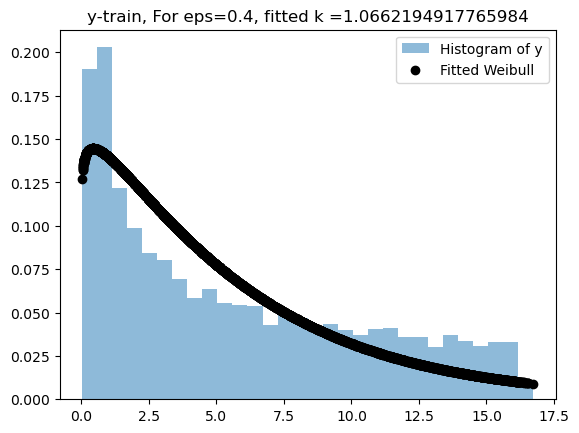

In [84]:
rv = sc_stats.weibull_min.fit(y_train, floc=0.0)
print (rv)
plt.hist(y_train,alpha=0.5,density=True,bins=30,label="Histogram of y")
plt.scatter(y_train, sc_stats.weibull_min.pdf(y_train,*rv),label="Fitted Weibull",color="black")
plt.title("y-train, For eps=0.4, fitted k =1.0662194917765984")
plt.legend()

In [62]:
result_df.reset_index().groupby('eps').loc[:,("loss","benchmark","train")].rank()

AttributeError: 'DataFrameGroupBy' object has no attribute 'loc'

In [55]:
result_df.groupby(["eps"]).loc[:,("loss","benchmark","train")].rank()

AttributeError: 'DataFrameGroupBy' object has no attribute 'loc'

In [ ]:
benchmark = result_df[result_df.model_type=="benchmark"]
benchmark["rnk_"] = benchmark.groupby(["eps","model_type"])["mse"].rank()
best_benchmark = benchmark[benchmark["rnk_"]==1]

proposed = result_df[result_df.model_type=="proposed"]
proposed["rnk_"] = proposed.groupby(["eps","model_type"])["mse"].rank()
best_proposed = proposed[proposed["rnk_"]==1]

In [ ]:
best_results = best_benchmark.merge(best_proposed,on="eps",suffixes=("_bench","_prop"))
best_results

In [ ]:
best_results[["eps","mse_bench","mse_prop","NLL_bench","NLL_prop"]]

In [ ]:
proposed

In [ ]:
benchmark[benchmark["rnk_"]==1]

In [ ]:
# mu_prop_i, var_prop_i,\
#             y_pred_prop_i, proposed_model_i = synthetic.results_weibull_model(c_i,x_train,y_train,x_test,k,1)

In [ ]:
# synthetic.results_weibull_model(c_i,x_train,y_train,x_test,k,1)

from scipy.special import loggamma

In [ ]:
def my_func(x):
    a = gamma(x-(2/1.3))
    b = gamma(x)
    c = gamma(x-(1/1.3))
    d = gamma(x)
    return (a/b)-(c/d)**2

In [ ]:
x = np.linspace(2.0,10,100)
plt.plot(x,my_func(x))